## Setup

In [1]:
# from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
from sklearn.model_selection import train_test_split
import json

In [4]:
tf.__version__

'2.0.0'

In [5]:
# A few constants
TRAIN_PERCENT = 0.8
SEED = 42
# SEED = None

## Prep data

In [6]:
# set image path
data_dir = pathlib.Path('../data/raw/images')
data_dir

WindowsPath('../data/raw/images')

In [7]:
# count size of dataset
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

5387

In [8]:
# count number of classes
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*')])
CLASS_NAMES

array(['epee', 'foil', 'not_fencing', 'sabre'], dtype='<U11')

In [9]:
grouped_list = []
for c in CLASS_NAMES:
    class_list = list(data_dir.glob(c+'/*'))
    grouped_list.append(class_list)

In [10]:
train_list = []
test_list = []

for class_list in grouped_list:
    class_train, class_test = train_test_split(class_list, train_size=TRAIN_PERCENT, random_state=SEED)
    train_list = train_list + class_train
    test_list = test_list + class_test

train_list = [str(file_path) for file_path in train_list]
test_list = [str(file_path) for file_path in test_list]

image_count == len(train_list) + len(test_list)

True

In [11]:
train_image_count = len(train_list)
train_image_count

4308

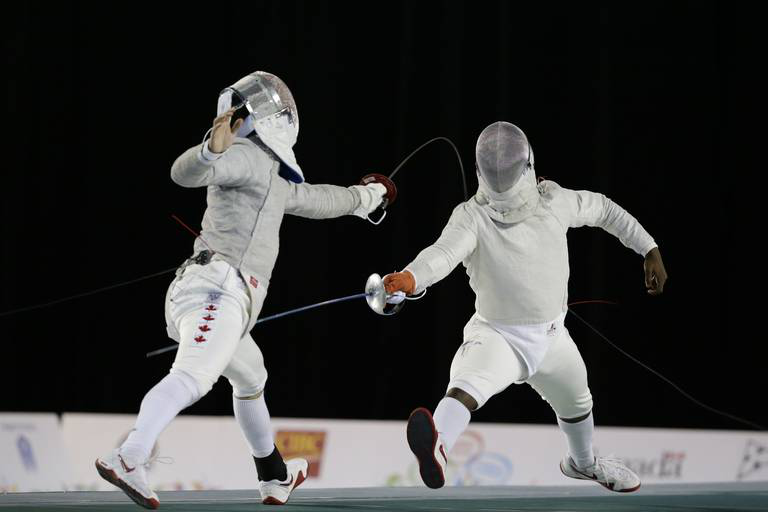

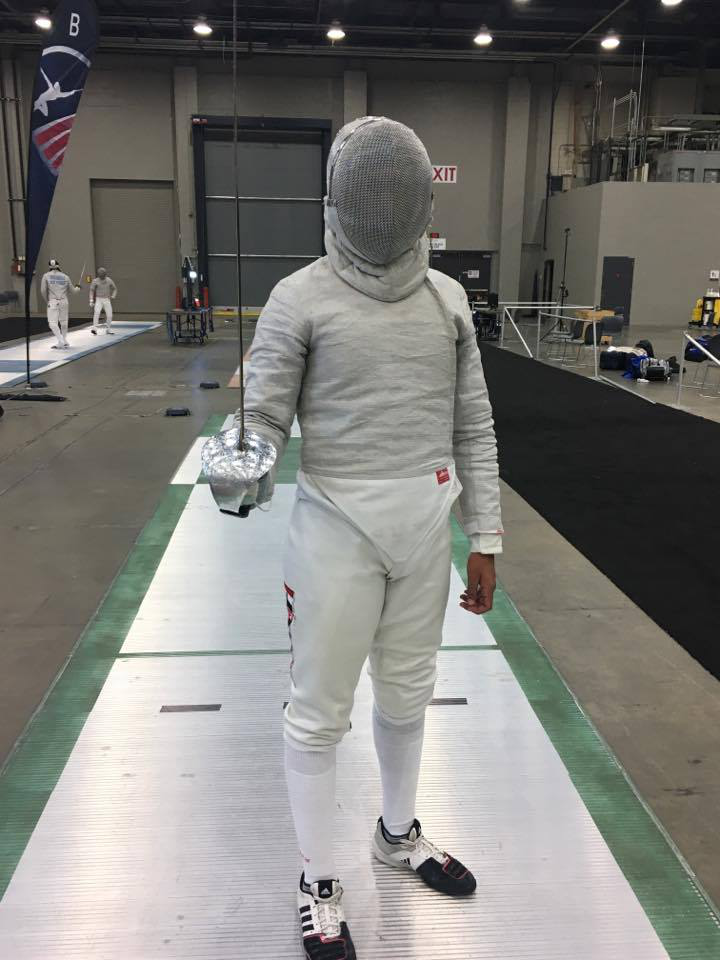

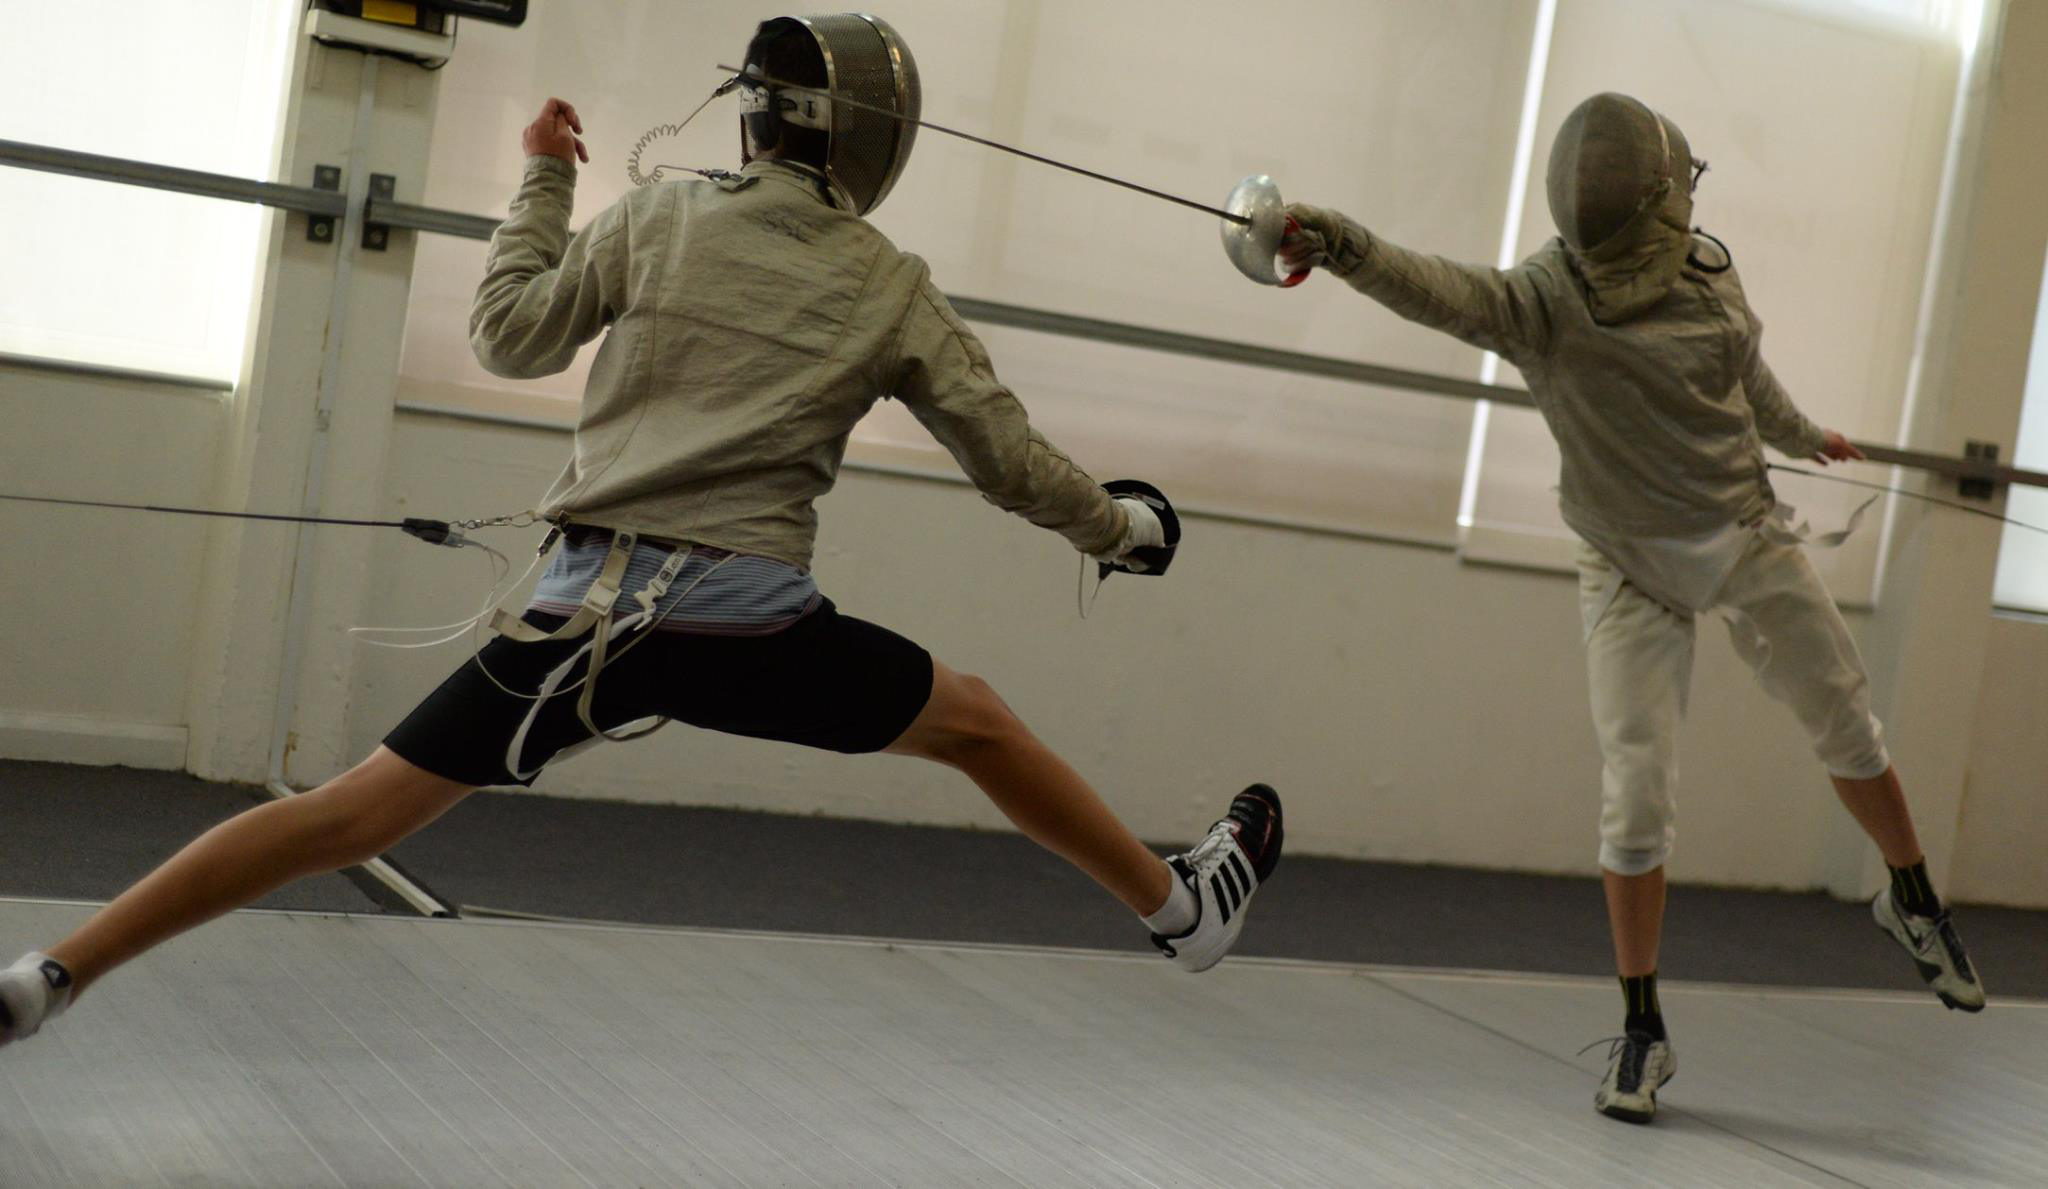

In [12]:
# preview some images from one class
sabre = list(data_dir.glob('sabre/*'))

for image_path in sabre[:3]:
    display.display(Image.open(str(image_path)))

## Load using tf.data

In [13]:
# Define loader parameters
BATCH_SIZE = 28
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = int(np.ceil(train_image_count/BATCH_SIZE))
STEPS_PER_EPOCH

154

In [14]:
#create a dataset of the file paths:
list_ds = tf.data.Dataset.from_tensor_slices(train_list)

for f in list_ds.take(5):
    print(f.numpy())

b'..\\data\\raw\\images\\epee\\000000000648.jpg'
b'..\\data\\raw\\images\\epee\\000000000860.jpg'
b'..\\data\\raw\\images\\epee\\000000000457.jpg'
b'..\\data\\raw\\images\\epee\\000000000015.jpg'
b'..\\data\\raw\\images\\epee\\000000000592.jpg'


In [15]:
# Pure tf function that converts a file paths to an (image_data, label) pair:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return tf.argmax(tf.cast(parts[-2] == CLASS_NAMES, dtype=tf.float32))

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [16]:
#Create dataset of image, label pairs
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  0


In [17]:
type(labeled_ds)

tensorflow.python.data.ops.dataset_ops.ParallelMapDataset

To train a model with this dataset you will want the data:

- To be well shuffled.
- To be batched.
- Batches to be available as soon as possible.

These features can be easily added using the tf.data api.

In [18]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000, b_size=BATCH_SIZE):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
            
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(b_size)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [19]:
train_ds = prepare_for_training(labeled_ds)

In [20]:
image_batch, label_batch = next(iter(train_ds))
# show_batch(image_batch.numpy(), label_batch.numpy())

In [21]:
labeled_ds

<ParallelMapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>

In [22]:
image_batch

<tf.Tensor: id=130, shape=(28, 224, 224, 3), dtype=float32, numpy=
array([[[[1.81952789e-01, 1.89795926e-01, 1.46658674e-01],
         [1.41456589e-01, 1.49299726e-01, 1.06162466e-01],
         [8.63945112e-02, 9.42376480e-02, 5.32612614e-02],
         ...,
         [9.07165036e-02, 8.67949352e-02, 6.71870932e-02],
         [1.13245353e-01, 1.13245353e-01, 8.01920593e-02],
         [1.11044154e-01, 1.11044154e-01, 7.18284622e-02]],

        [[2.02761114e-01, 2.10604250e-01, 1.67466998e-01],
         [6.26650825e-02, 7.05082119e-02, 2.73709595e-02],
         [1.75950363e-01, 1.83793500e-01, 1.40656248e-01],
         ...,
         [1.00560367e-01, 9.66387987e-02, 7.70309493e-02],
         [1.18487440e-01, 1.18487440e-01, 8.54341388e-02],
         [1.16166256e-01, 1.16166256e-01, 7.69505650e-02]],

        [[3.17607045e-01, 3.25450182e-01, 2.82312930e-01],
         [1.58783525e-01, 1.66626662e-01, 1.23489410e-01],
         [1.66266516e-01, 1.74109653e-01, 1.30972400e-01],
         ...,
  

## Build the model

### Set up the layers
The basic building block of a neural network is the layer. Layers extract representations from the data fed into them. Hopefully, these representations are meaningful for the problem at hand.

Most of deep learning consists of chaining together simple layers. Most layers, such as `tf.keras.layers.Dense`, have parameters that are learned during training.

In [23]:
# A simple model

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    keras.layers.Dense(96, activation='relu'),
    keras.layers.Dense(4, activation='softmax')
])

The first layer in this network, tf.keras.layers.Flatten, transforms the format of the images from a two-dimensional array (of IMG_WIDTH by IMG_HEIGHT pixels) to a one-dimensional array (of IMG_WIDTH * IMG_HEIGHT pixels). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two `tf.keras.layers.Dense` layers. These are densely connected, or fully connected, neural layers. The first Dense layer has 128 nodes (or neurons). The second (and last) layer is a 4-node softmax layer that returns an array of 4 probability scores that sum to 1. Each node contains a score that indicates the probability that the current image belongs to one of the 4 classes.

#### Compile the model
Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:

- Loss function —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
- Optimizer —This is how the model is updated based on the data it sees and its loss function.
- Metrics —Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.

In [24]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# model.fit(image_batch.numpy(), label_batch.numpy(), epochs=2)

In [ ]:
model.fit(train_ds, steps_per_epoch=STEPS_PER_EPOCH, epochs=15)

Train for 154 steps
Epoch 1/15
154/154 [==============================] - 21s 136ms/step - loss: 16.2908 - accuracy: 0.7632
Epoch 2/15
154/154 [==============================] - 10s 62ms/step - loss: 2.4818 - accuracy: 0.7781
Epoch 3/15
154/154 [==============================] - 6s 41ms/step - loss: 0.6490 - accuracy: 0.7730
Epoch 4/15
154/154 [==============================] - 6s 41ms/step - loss: 0.7181 - accuracy: 0.8101
Epoch 5/15
154/154 [==============================] - 6s 42ms/step - loss: 0.5580 - accuracy: 0.8177
Epoch 6/15
154/154 [==============================] - 7s 47ms/step - loss: 0.5763 - accuracy: 0.8166
Epoch 7/15
154/154 [==============================] - 7s 45ms/step - loss: 0.4904 - accuracy: 0.8161
Epoch 8/15
154/154 [==============================] - 7s 45ms/step - loss: 0.4679 - accuracy: 0.8173
Epoch 9/15
154/154 [==============================] - 6s 42ms/step - loss: 0.4623 - accuracy: 0.8147
Epoch 10/15
 35/154 [=====>........................] - ETA: 5s - lo

# Model evaluation

### prepare test dataset

In [ ]:
#create a dataset of the file paths:
test_list_ds = tf.data.Dataset.from_tensor_slices(test_list)

for f in test_list_ds.take(5):
    print(f.numpy())

In [ ]:
#Create dataset of image, label pairs
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
test_labeled_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in test_labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

In [ ]:
test_ds = prepare_for_training(test_labeled_ds, b_size=len(test_list))

In [ ]:
test_loss, test_acc = model.evaluate(test_ds, steps=1, verbose=2)

In [ ]:
model